In [1]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression

# import pingouin

In [2]:
# Factor analysis in gpt3-human-nlp dir

In [3]:
expert1_file = '/cronus_data/avirinchipur/reasoning_for_psych/expts/parsed_responses/Item_level_scores_Katarina.csv'
expert2_file = '/cronus_data/avirinchipur/reasoning_for_psych/expts/parsed_responses/Item_level_scores_Veerle.csv'
self_report_file = '/cronus_data/avirinchipur/reasoning_for_psych/expts/parsed_responses/self_report_unified.csv'
gpt4_file = '/cronus_data/avirinchipur/reasoning_for_psych/expts/parsed_responses/expt_gpt-4-1106-preview.dep_list_phq9items_score_classify2_editted_unified.csv'

In [4]:
expert1_df = pd.read_csv(expert1_file)
expert2_df = pd.read_csv(expert2_file)
self_report_df = pd.read_csv(self_report_file)
gpt4_df = pd.read_csv(gpt4_file)

In [5]:
symptoms_columns = ['Anhedonia', 'Depressed_Mood', 'Insomnia_or_Hypersomnia',
       'Fatigue', 'Poor_appetite_or_overeating', 'Worthlessness_or_Guilt',
       'Difficulty_concentrating', 'Psychomotor_agitation_or_retardation',
       'Suicidal_ideation']
       
score_columns = ['score_Anhedonia', 'score_Depressed_Mood',
       'score_Insomnia_or_Hypersomnia', 'score_Fatigue',
       'score_Poor_appetite_or_overeating', 'score_Worthlessness_or_Guilt',
       'score_Difficulty_concentrating',
       'score_Psychomotor_agitation_or_retardation', 'score_Suicidal_ideation']

isInferred_columns = ['isInferred_Anhedonia', 'isInferred_Depressed_Mood',
         'isInferred_Insomnia_or_Hypersomnia', 'isInferred_Fatigue',
         'isInferred_Poor_appetite_or_overeating',
         'isInferred_Worthlessness_or_Guilt',
         'isInferred_Difficulty_concentrating',
         'isInferred_Psychomotor_agitation_or_retardation',
         'isInferred_Suicidal_ideation']

In [6]:
expert1_df = expert1_df.fillna(0)
expert2_df = expert2_df.fillna(0)

### Base rates of Explicit/Implicit Co-occurrance

In [7]:
temp = (gpt4_df.shape[0] - gpt4_df[isInferred_columns].sum(axis=0)).to_dict()
gpt4_symptoms_explicit_occ = {}
for key, val in temp.items():
    gpt4_symptoms_explicit_occ[key.replace('isInferred_', '')] = val
gpt4_symptoms_explicit_occ

{'Anhedonia': 513,
 'Depressed_Mood': 921,
 'Insomnia_or_Hypersomnia': 108,
 'Fatigue': 240,
 'Poor_appetite_or_overeating': 48,
 'Worthlessness_or_Guilt': 231,
 'Difficulty_concentrating': 90,
 'Psychomotor_agitation_or_retardation': 32,
 'Suicidal_ideation': 53}

In [8]:
# Create a df with % explicit and % implicit occurences for each symptom
symptoms_explicit_occ = {}

for symptom in symptoms_columns:
    symptoms_explicit_occ[symptom] = gpt4_symptoms_explicit_occ[symptom] / gpt4_df.shape[0]

symptoms_explicit_occ_df = pd.DataFrame(symptoms_explicit_occ, index=['gpt4'])
symptoms_explicit_occ_df = symptoms_explicit_occ_df.T

symptoms_explicit_occ_df

,gpt4
Anhedonia,0.537173
Depressed_Mood,0.964398
Insomnia_or_Hypersomnia,0.113089
Fatigue,0.251309
Poor_appetite_or_overeating,0.050262
Worthlessness_or_Guilt,0.241885
Difficulty_concentrating,0.094241
Psychomotor_agitation_or_retardation,0.033508
Suicidal_ideation,0.055497


In [9]:
# Caluclate the correlation between gpt4 and self report for each symptom under two conditions, 
# 1. considering only the explicit occurences
# 2. considering only implicit occurences

gpt4_sr_exp_imp_pearsonr = []
for symptom in symptoms_columns:
    exp_rows = gpt4_df[gpt4_df['isInferred_'+symptom] == 0].user_id.tolist()
    imp_rows = gpt4_df[gpt4_df['isInferred_'+symptom] == 1].user_id.tolist()
    symptom_scores = 'score_' + symptom
    gpt4_sr_merge_exp = gpt4_df[gpt4_df['user_id'].isin(exp_rows)][['user_id', symptom_scores]].merge(self_report_df[['user_id', symptom_scores]], on='user_id')
    gpt4_sr_merge_imp = gpt4_df[gpt4_df['user_id'].isin(imp_rows)][['user_id', symptom_scores]].merge(self_report_df[['user_id', symptom_scores]], on='user_id')
    exp_pearsonr, _ = pearsonr(gpt4_sr_merge_exp[symptom_scores+'_x'], gpt4_sr_merge_exp[symptom_scores+'_y'])
    imp_pearsonr, _ = pearsonr(gpt4_sr_merge_imp[symptom_scores+'_x'], gpt4_sr_merge_imp[symptom_scores+'_y'])
    temp = [symptom, round(100*len(exp_rows)/gpt4_df.shape[0], 2), round(exp_pearsonr, 2), round(100*len(imp_rows)/gpt4_df.shape[0], 2), round(imp_pearsonr, 2)]
    gpt4_sr_exp_imp_pearsonr.append(temp)

pd.DataFrame(gpt4_sr_exp_imp_pearsonr, columns=['symptom', 'explicit %', 'explicit_pearsonr', 'implicit %', 'implicit_pearsonr'])    

,symptom,explicit %,explicit_pearsonr,implicit %,implicit_pearsonr
0,Anhedonia,53.72,0.71,46.28,0.43
1,Depressed_Mood,96.44,0.70,3.56,0.44
2,Insomnia_or_Hypersomnia,11.31,0.52,88.69,0.43
3,Fatigue,25.13,0.58,74.87,0.51
4,Poor_appetite_or_overeating,5.03,0.47,94.97,0.33
5,Worthlessness_or_Guilt,24.19,0.57,75.81,0.45
6,Difficulty_concentrating,9.42,0.50,90.58,0.45
7,Psychomotor_agitation_or_retardation,3.35,0.33,96.65,0.24
8,Suicidal_ideation,5.55,0.75,94.45,0.21


In [10]:
gpt4_exp_imp_pair_occ = np.zeros((len(symptoms_columns), len(symptoms_columns)), dtype=int)
for idx, symptom_exp in enumerate(isInferred_columns):
    for jdx, symptom_imp in enumerate(isInferred_columns):
        if idx == jdx: continue
        gpt4_exp_imp_pair_occ[idx, jdx] = ((gpt4_df[symptom_exp]==0) & (gpt4_df[symptom_imp]==1)).sum()
        
gpt4_exp_imp_pair_occ

array([[  0,  15, 462, 395, 486, 433, 474, 504, 493],
       [423,   0, 821, 697, 877, 695, 844, 891, 870],
       [ 57,   8,   0,  53,  88,  87,  90, 103, 104],
       [122,  16, 185,   0, 219, 172, 204, 227, 224],
       [ 21,   4,  28,  27,   0,  30,  39,  44,  45],
       [151,   5, 210, 163, 213,   0, 210, 225, 201],
       [ 51,  13,  72,  54,  81,  69,   0,  88,  83],
       [ 23,   2,  27,  19,  28,  26,  30,   0,  30],
       [ 33,   2,  49,  37,  50,  23,  46,  51,   0]])

In [11]:
((gpt4_df['isInferred_Depressed_Mood']==0) & (gpt4_df['isInferred_Poor_appetite_or_overeating']==1)).sum()

877

In [18]:
from matplotlib import font_manager
font_path = '/usr/share/fonts/truetype/msttcorefonts/Times_New_Roman.ttf'
bold_font_path = '/usr/share/fonts/truetype/msttcorefonts/Times_New_Roman_Bold.ttf'
italics_font_path = '/usr/share/fonts/truetype/msttcorefonts/Times_New_Roman_Italic.ttf'
# Create a font properties object
custom_font = font_manager.FontProperties(fname=font_path)
custom_font_bold = font_manager.FontProperties(fname=bold_font_path)
custom_font_italics = font_manager.FontProperties(fname=italics_font_path)

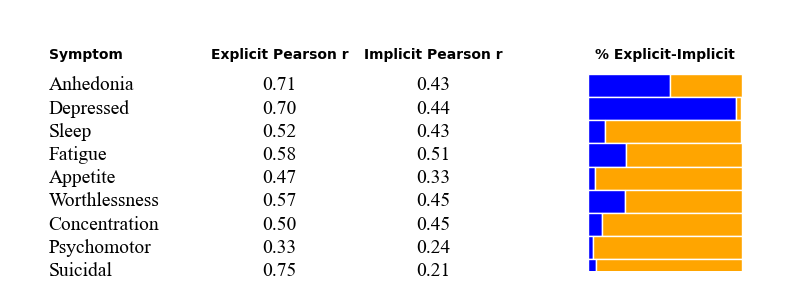

In [29]:
import matplotlib.pyplot as plt
import pandas as pd

# Data from the table
data = {
    'symptom': ['Anhedonia', 'Depressed', 'Sleep', 'Fatigue', 'Appetite', 'Worthlessness', 'Concentration', 'Psychomotor', 'Suicidal'],
    'explicit%': [53.72, 96.44, 11.31, 25.13, 5.03, 24.19, 9.42, 3.35, 5.55],
    'explicit_pearsonr': [0.71, 0.70, 0.52, 0.58, 0.47, 0.57, 0.50, 0.33, 0.75],
    'implicit%': [46.28, 3.56, 88.69, 74.87, 94.97, 75.81, 90.58, 96.65, 94.45],
    'implicit_pearsonr': [0.43, 0.44, 0.43, 0.51, 0.33, 0.45, 0.45, 0.24, 0.21]
}

df = pd.DataFrame(data)

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(8, 3))

# Set the limits and hide the axes
ax.set_xlim(0, 1)
ax.set_ylim(0, len(df))
ax.axis('off')

# Define column positions
x_symptom = 0.05
x_explicit_r = 0.35
x_implicit_r = 0.55
x_bar_chart_start = 0.75  # Start of the bar chart in x-axis
x_bar_chart_width = 0.2  # Width allocated for the bar chart

row_height = 0.8

# Loop through each row of the data to create the table
for i, row in df.iterrows():
    y = len(df) - i - 1  # Invert the row number for plotting
    
    # Add text for symptoms and Pearson r values
    ax.text(x_symptom, y * row_height, row['symptom'], va='center', ha='left', fontproperties=custom_font, fontsize=14)
    ax.text(x_explicit_r, y * row_height, f"{row['explicit_pearsonr']:.2f}", va='center', ha='center', fontproperties=custom_font, fontsize=14)
    ax.text(x_implicit_r, y * row_height, f"{row['implicit_pearsonr']:.2f}", va='center', ha='center', fontproperties=custom_font, fontsize=14)
    
    # Normalize the bar chart to fit within the allocated space (x_bar_chart_width)
    total = row['explicit%'] + row['implicit%']
    explicit_fraction = row['explicit%'] / total
    implicit_fraction = row['implicit%'] / total
    
    # Draw the explicit and implicit bar charts within the last column
    ax.barh(y * row_height, explicit_fraction * x_bar_chart_width, height=0.8, left=x_bar_chart_start, color='blue', edgecolor='white')
    ax.barh(y * row_height, implicit_fraction * x_bar_chart_width, height=0.8, left=x_bar_chart_start + (explicit_fraction * x_bar_chart_width), color='orange', edgecolor='white')

# Add column labels
ax.text(x_symptom, len(df) * row_height, "Symptom", va='bottom', ha='left', weight='bold')
ax.text(x_explicit_r, len(df) * row_height, "Explicit Pearson r", va='bottom', ha='center', weight='bold')
ax.text(x_implicit_r, len(df) * row_height, "Implicit Pearson r", va='bottom', ha='center', weight='bold')
ax.text(x_bar_chart_start + x_bar_chart_width / 2, len(df) * row_height, "% Explicit-Implicit", va='bottom', ha='center', weight='bold')

# Adjust layout and display
plt.tight_layout()
# plt.savefig("table_with_bar_contained.pdf", bbox_inches='tight')
plt.show()


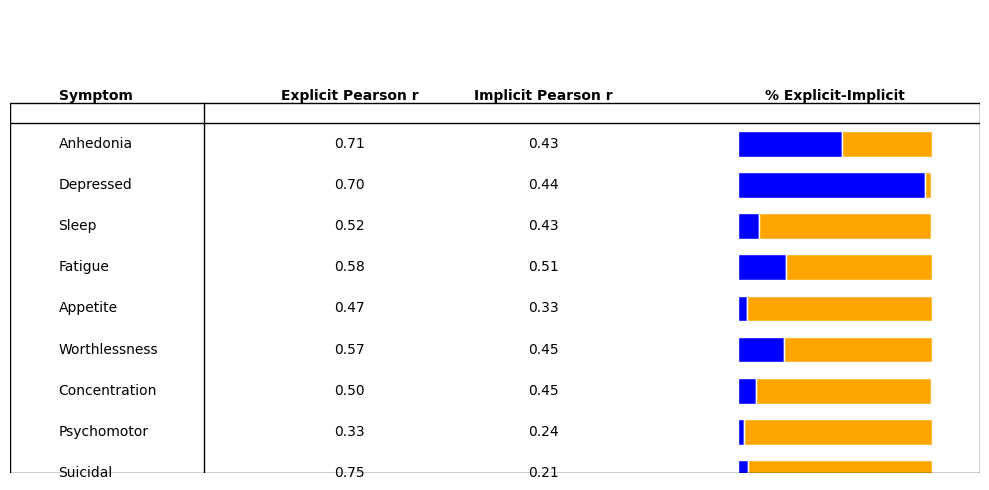

In [30]:
import matplotlib.pyplot as plt
import pandas as pd

# Data from the table
data = {
    'symptom': ['Anhedonia', 'Depressed', 'Sleep', 'Fatigue', 'Appetite', 'Worthlessness', 'Concentration', 'Psychomotor', 'Suicidal'],
    'explicit%': [53.72, 96.44, 11.31, 25.13, 5.03, 24.19, 9.42, 3.35, 5.55],
    'explicit_pearsonr': [0.71, 0.70, 0.52, 0.58, 0.47, 0.57, 0.50, 0.33, 0.75],
    'implicit%': [46.28, 3.56, 88.69, 74.87, 94.97, 75.81, 90.58, 96.65, 94.45],
    'implicit_pearsonr': [0.43, 0.44, 0.43, 0.51, 0.33, 0.45, 0.45, 0.24, 0.21]
}

df = pd.DataFrame(data)

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(10, 5))

# Set the limits and hide the axes
ax.set_xlim(0, 1)
ax.set_ylim(0, len(df))
ax.axis('off')

# Define column positions
x_symptom = 0.05
x_explicit_r = 0.35
x_implicit_r = 0.55
x_bar_chart_start = 0.75  # Start of the bar chart in x-axis
x_bar_chart_width = 0.2  # Width allocated for the bar chart

row_height = 0.8  # Adjusted row height for more compact bars

# Loop through each row of the data to create the table
for i, row in df.iterrows():
    y = len(df) - i - 1  # Invert the row number for plotting
    
    # Add text for symptoms and Pearson r values
    ax.text(x_symptom, y * row_height, row['symptom'], va='center', ha='left')
    ax.text(x_explicit_r, y * row_height, f"{row['explicit_pearsonr']:.2f}", va='center', ha='center')
    ax.text(x_implicit_r, y * row_height, f"{row['implicit_pearsonr']:.2f}", va='center', ha='center')
    
    # Normalize the bar chart to fit within the allocated space (x_bar_chart_width)
    total = row['explicit%'] + row['implicit%']
    explicit_fraction = row['explicit%'] / total
    implicit_fraction = row['implicit%'] / total
    
    # Draw the explicit and implicit bar charts within the last column
    ax.barh(y * row_height, explicit_fraction * x_bar_chart_width, height=0.5, left=x_bar_chart_start, color='blue', edgecolor='white')
    ax.barh(y * row_height, implicit_fraction * x_bar_chart_width, height=0.5, left=x_bar_chart_start + (explicit_fraction * x_bar_chart_width), color='orange', edgecolor='white')

# Add column labels with a horizontal line underneath
ax.text(x_symptom, len(df) * row_height, "Symptom", va='bottom', ha='left', weight='bold')
ax.text(x_explicit_r, len(df) * row_height, "Explicit Pearson r", va='bottom', ha='center', weight='bold')
ax.text(x_implicit_r, len(df) * row_height, "Implicit Pearson r", va='bottom', ha='center', weight='bold')
ax.text(x_bar_chart_start + x_bar_chart_width / 2, len(df) * row_height, "% Explicit-Implicit", va='bottom', ha='center', weight='bold')

# Draw the horizontal line separating the column headers
ax.plot([0, 1], [len(df) * row_height - row_height / 2, len(df) * row_height - row_height / 2], color='black', lw=1)

# Add bounding box for the entire table
ax.plot([0, 1, 1, 0, 0], [0, 0, len(df) * row_height, len(df) * row_height, 0], color='black', lw=1)

# Add vertical line between Symptom and Pearson r columns
ax.plot([x_explicit_r - 0.15, x_explicit_r - 0.15], [0, len(df) * row_height], color='black', lw=1)

# Adjust layout and display
plt.tight_layout()
# plt.savefig("table_with_bounding_box_and_lines.pdf", bbox_inches='tight')
plt.show()


### Calculating P(exp=a and imp=b) for each symptom pair

<AxesSubplot:>

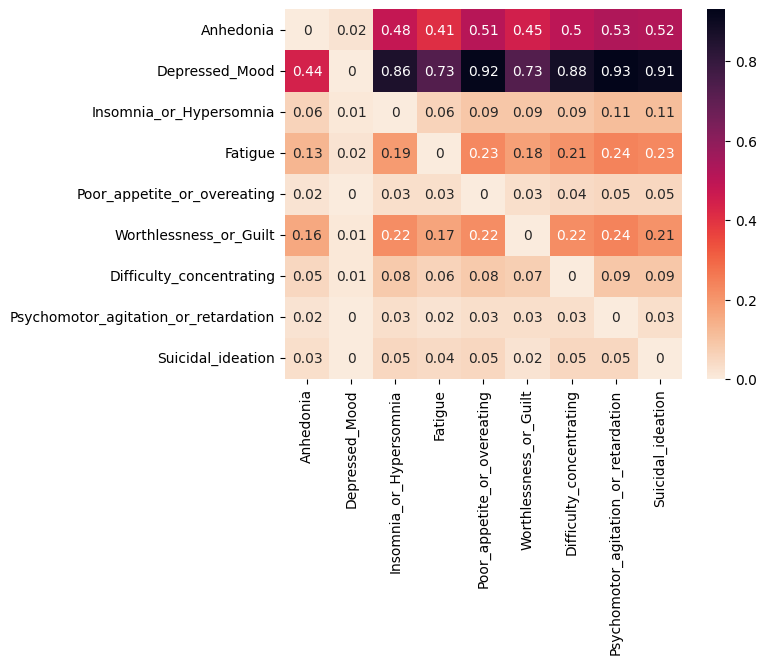

In [12]:
temp_df = (gpt4_exp_imp_pair_occ/float(len(gpt4_df)))
temp_df = pd.DataFrame(temp_df, columns=symptoms_columns, index=symptoms_columns)
sns.heatmap(temp_df.round(2), annot=True, cmap='rocket_r')

<AxesSubplot:>

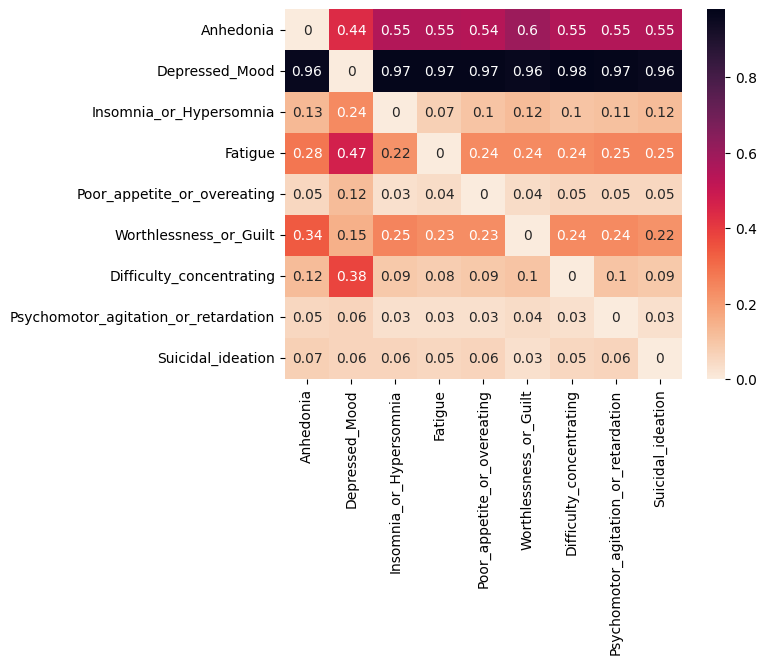

In [13]:
## Calculate  P(exp=A | imp=b)
temp_df2 = gpt4_exp_imp_pair_occ.copy().astype(float)
for idx, symptom in enumerate(symptoms_columns):
    temp_df2[:, idx] = gpt4_exp_imp_pair_occ[:, idx]/float(gpt4_df.shape[0] - gpt4_symptoms_explicit_occ[symptom])
    
temp_df2 = pd.DataFrame(temp_df2, columns=symptoms_columns, index=symptoms_columns)
sns.heatmap(temp_df2.round(2), annot=True, cmap='rocket_r')

<AxesSubplot:>

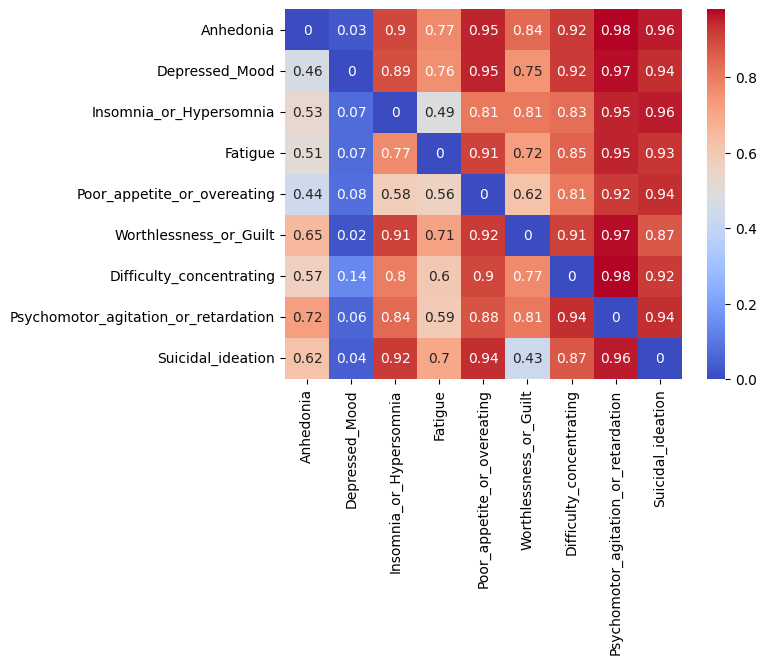

In [14]:
## Calculate P(imp=b | exp=A)
temp_df3 = gpt4_exp_imp_pair_occ.copy().astype(float)
for idx, symptom in enumerate(symptoms_columns):
    temp_df3[idx, :] = gpt4_exp_imp_pair_occ[idx,:]/float(gpt4_symptoms_explicit_occ[symptom])
    
temp_df3 = pd.DataFrame(temp_df3, columns=symptoms_columns, index=symptoms_columns)
sns.heatmap(temp_df3.round(2), annot=True, cmap='coolwarm')

## Training models to understand the effect explicit scores on implicit symptoms

In [15]:
def get_symptom_scores(df:pd.DataFrame, imp_symptom:str, infill=None):
    exp_columns = symptoms_columns.copy()
    exp_columns.remove(imp_symptom)
    exp_columns_isInferred = ['isInferred_'+symptom for symptom in exp_columns]
    exp_columns_score = ['score_'+ symptom for symptom in exp_columns]
    y = df[df['isInferred_'+imp_symptom]==1]['score_'+imp_symptom]
    X = df[df['isInferred_'+imp_symptom]==1][exp_columns_score]
    z = df[df['isInferred_'+imp_symptom]==1][exp_columns_isInferred]
    
    if infill == 'zero':
        # for each column, turn the rows that had implicit mention of symptoms in X to  0
        for column in exp_columns: X.loc[z['isInferred_'+column]==1, 'score_'+column] = 0
    elif infill == 'mean':
        # for each column, turn the rows that had implicit mention of symptoms in X to mean of the column when it was explicit
        for column in exp_columns:
            mean_val = X.loc[z['isInferred_'+column]==0, 'score_'+column].mean()
            if np.isnan(mean_val): mean_val = 0
            X.loc[z['isInferred_'+column]==1, 'score_'+column] = mean_val
    
    return X, y, exp_columns    

<AxesSubplot:>

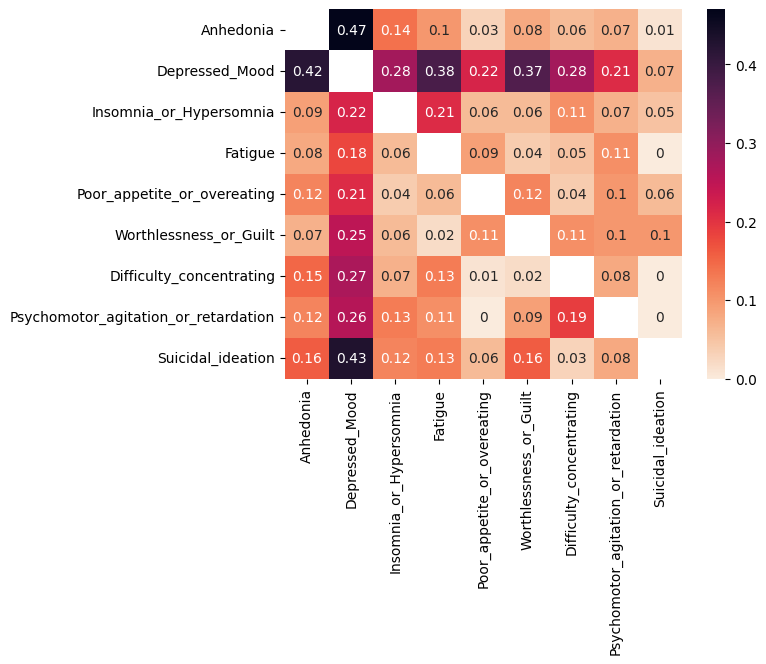

In [16]:
# Infill strategy is 0
multivariate_coef = {}
for column in symptoms_columns:
    X, y, cols = get_symptom_scores(gpt4_df, column, infill='zero')
    lr = LinearRegression(positive=True)
    lr.fit(X, y)
    multivariate_coef[column] = dict(zip(cols, lr.coef_))
    # multivariate_coef[column]['n'] = (len(X))

multivariate_coef = pd.DataFrame(multivariate_coef).round(2)
sns.heatmap(multivariate_coef.reindex(symptoms_columns), annot=True, cmap='rocket_r')

In [17]:
# Infill strategy is mean
multivariate_coef2 = {}
for column in symptoms_columns:
    X, y, cols = get_symptom_scores(gpt4_df, column, infill='mean')
    # lr = LinearRegression(positive=True)
    lr = LinearRegression()
    lr.fit(X, y)
    multivariate_coef2[column] = dict(zip(cols, lr.coef_))
    # multivariate_coef2[column]['n'] = (len(X))
    
multivariate_coef2 = pd.DataFrame(multivariate_coef2).round(2)
multivariate_coef2 = multivariate_coef2.loc[symptoms_columns]

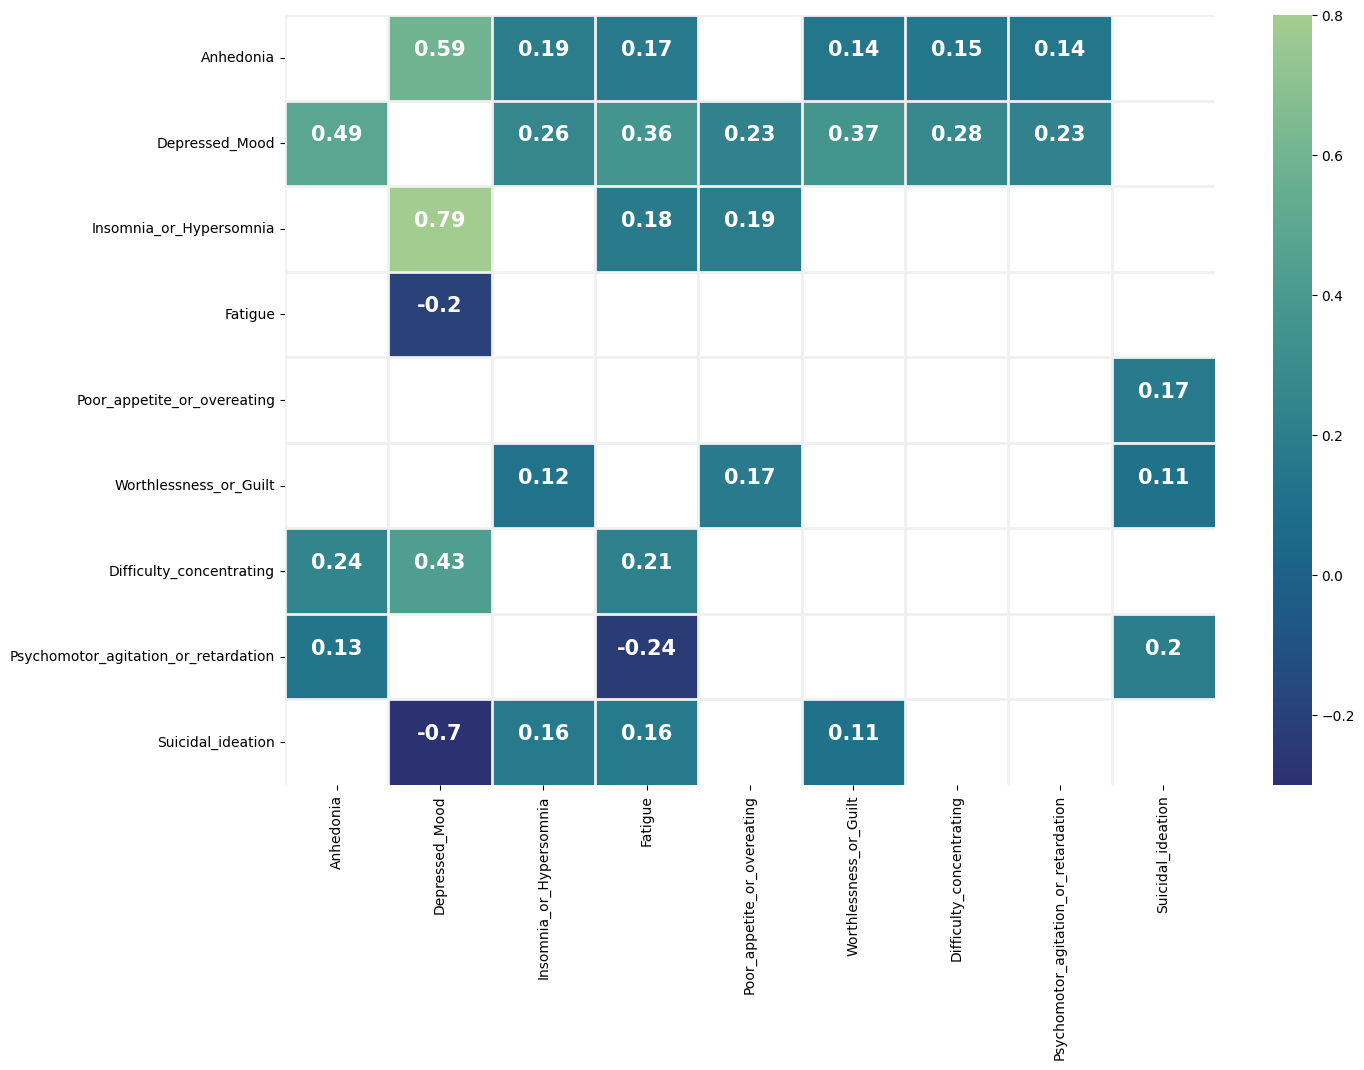

In [18]:
fig, ax = plt.subplots(figsize=(15, 10))
mask = np.zeros(multivariate_coef2.shape)
for idx in range(mask.shape[0]):
    for jdx in range(mask.shape[1]):
        if (idx == jdx) or np.abs(multivariate_coef2.iloc[idx, jdx]) <= 0.1:
            # print (idx, jdx, multivariate_coef2.iloc[idx, jdx])
            mask[idx, jdx] = True

mask = mask.astype(bool)
sns.heatmap(multivariate_coef2, annot=False, cmap='crest_r', fmt='', vmin=-0.3, vmax=0.8, mask=mask)

for i, col_i in enumerate(symptoms_columns):
    for j, col_j in enumerate(symptoms_columns):
        if not mask[i, j]:
            corr_text = str(multivariate_coef2.loc[col_i, col_j])
            ax.text(j + 0.5, i + 0.4, corr_text, ha='center', va='center',
                    fontsize=15, fontweight='bold', color='white')
            
for i in range(9):
    ax.axhline(i, color='#f0f0f0', lw=2)
    ax.axvline(i, color='#f0f0f0', lw=2)

In [19]:
for idx, symptom_exp in enumerate(multivariate_coef2.index):
    for jdx, symptom_imp in enumerate(multivariate_coef2.columns):
        if idx == jdx or np.abs(multivariate_coef2.iloc[idx, jdx]) <= 0.1: continue
        print ("{}_exp [{}] {}_imp".format(symptom_exp, multivariate_coef2.iloc[idx, jdx], symptom_imp))
    print ()

Anhedonia_exp [0.59] Depressed_Mood_imp
Anhedonia_exp [0.19] Insomnia_or_Hypersomnia_imp
Anhedonia_exp [0.17] Fatigue_imp
Anhedonia_exp [0.14] Worthlessness_or_Guilt_imp
Anhedonia_exp [0.15] Difficulty_concentrating_imp
Anhedonia_exp [0.14] Psychomotor_agitation_or_retardation_imp

Depressed_Mood_exp [0.49] Anhedonia_imp
Depressed_Mood_exp [0.26] Insomnia_or_Hypersomnia_imp
Depressed_Mood_exp [0.36] Fatigue_imp
Depressed_Mood_exp [0.23] Poor_appetite_or_overeating_imp
Depressed_Mood_exp [0.37] Worthlessness_or_Guilt_imp
Depressed_Mood_exp [0.28] Difficulty_concentrating_imp
Depressed_Mood_exp [0.23] Psychomotor_agitation_or_retardation_imp

Insomnia_or_Hypersomnia_exp [0.79] Depressed_Mood_imp
Insomnia_or_Hypersomnia_exp [0.18] Fatigue_imp
Insomnia_or_Hypersomnia_exp [0.19] Poor_appetite_or_overeating_imp

Fatigue_exp [-0.2] Depressed_Mood_imp

Poor_appetite_or_overeating_exp [0.17] Suicidal_ideation_imp

Worthlessness_or_Guilt_exp [0.12] Insomnia_or_Hypersomnia_imp
Worthlessness_or_Gu

In [20]:
# Infill strategy is mean, run the statistics for 100 trials and report avg coef. Store the std dev as well
multivariate_coef2_trials = {}
num_trials = 500
for trial_num in range(num_trials):
    df = gpt4_df.sample(frac=1, replace=True, random_state=trial_num)
    for column in symptoms_columns:
        X, y, cols = get_symptom_scores(df, column, infill='mean')
        lr = LinearRegression(positive=False)
        lr.fit(X, y)
        if column not in multivariate_coef2_trials:
            multivariate_coef2_trials[column] = []
        multivariate_coef2_trials[column].append(dict(zip(cols, lr.coef_)))

In [21]:
multivariate_coef2_avg = {}
multivariate_coef2_std = {}
multivariate_coef2_med = {}

for column in symptoms_columns:
    multivariate_coef2_avg[column] = pd.DataFrame(multivariate_coef2_trials[column]).T.mean(axis=1)
    multivariate_coef2_std[column] = pd.DataFrame(multivariate_coef2_trials[column]).T.std(axis=1)/np.sqrt(num_trials)
    multivariate_coef2_med[column] = pd.DataFrame(multivariate_coef2_trials[column]).T.median(axis=1)

multivariate_coef2_avg = pd.DataFrame(multivariate_coef2_avg).loc[symptoms_columns]
multivariate_coef2_std = pd.DataFrame(multivariate_coef2_std).loc[symptoms_columns]
multivariate_coef2_med = pd.DataFrame(multivariate_coef2_med).loc[symptoms_columns]

In [22]:
# Calculate the 90% confidence interval for the coefficients from multivariate_coef2
multivariate_coef2_ci = []
for idx, symptom in enumerate(symptoms_columns):
    coef_df = pd.DataFrame(multivariate_coef2_trials[symptom])
    coef_df = coef_df.T
    temp_df = coef_df.quantile([0.05, 0.95], axis=1).reset_index(drop=True).T.apply(lambda x: [round(x[0], 2), round(x[1], 2)], axis=1)
    temp_df = pd.DataFrame(temp_df, columns=[symptom]) 
    multivariate_coef2_ci.append(temp_df)
multivariate_coef2_ci = pd.concat(multivariate_coef2_ci, axis=1).loc[symptoms_columns]

Text(0.5, 1.0, 'Median Coefficients for 500 trials with 90% CI\n')

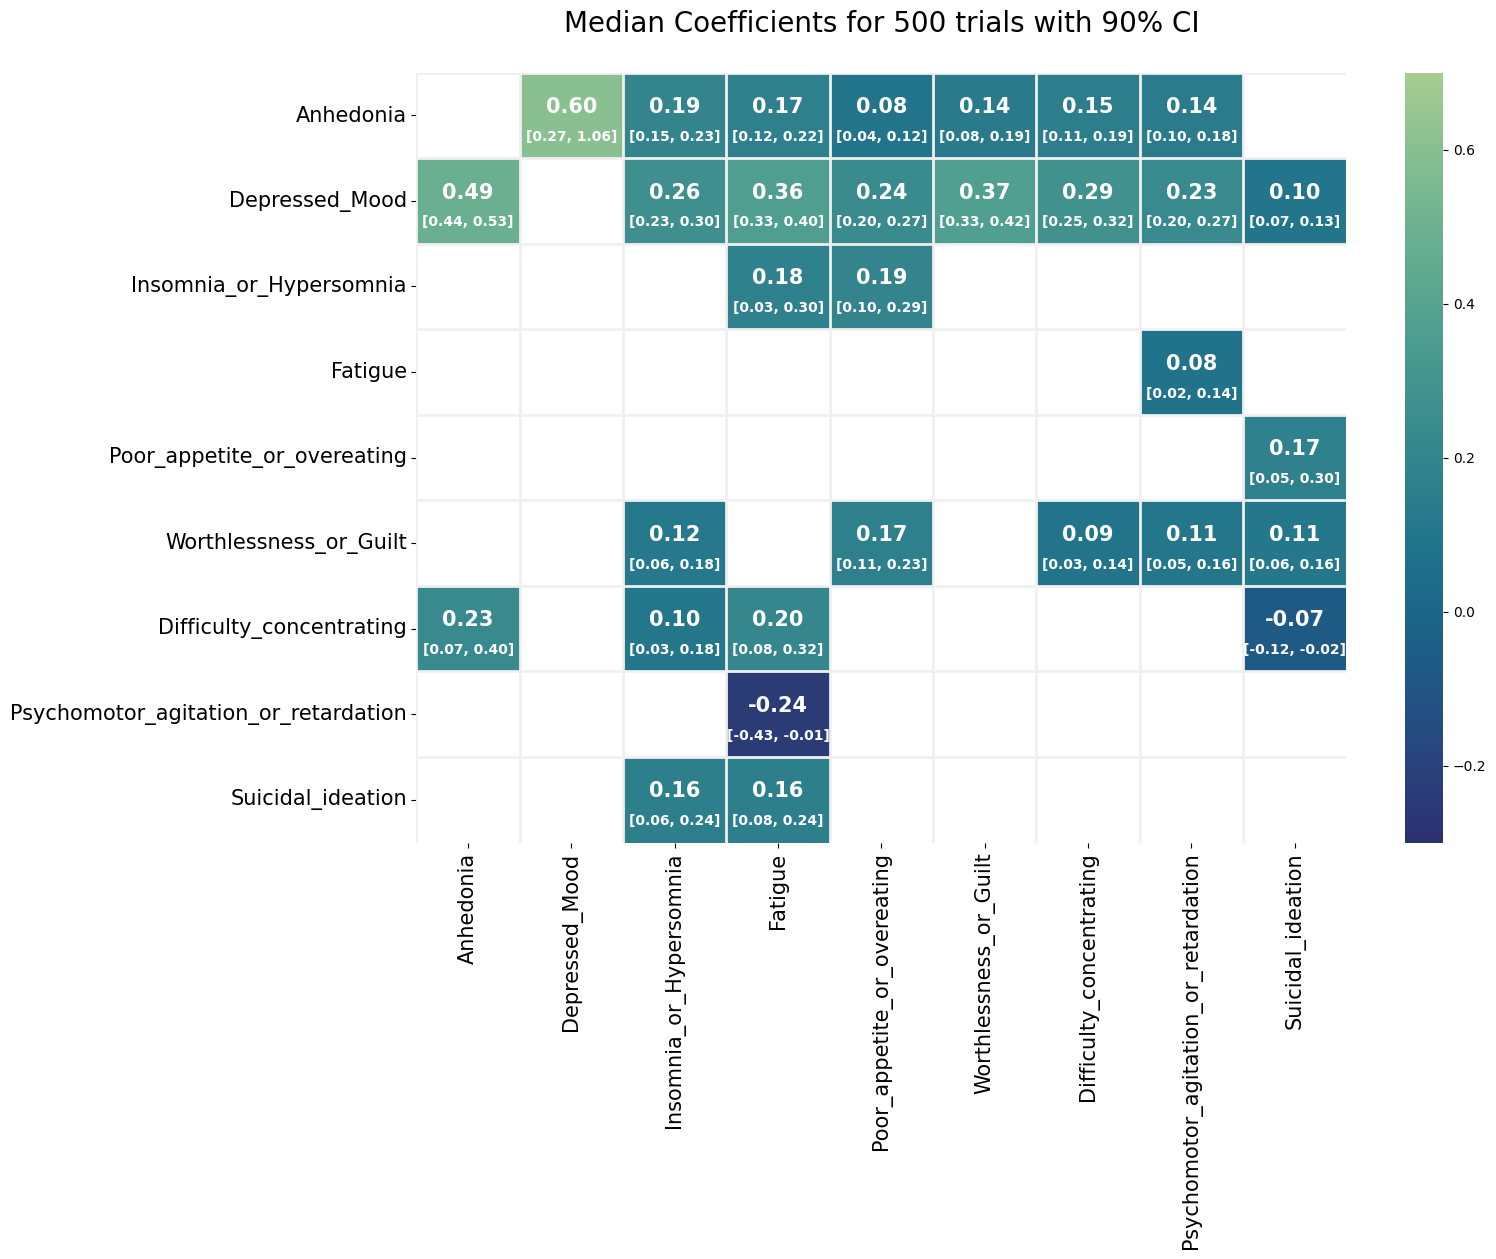

In [23]:
# multivariate_coef2_avg
fig, ax = plt.subplots(figsize=(15, 10))
mask = np.zeros_like(multivariate_coef2_med)
for idx in range(mask.shape[0]):
    for jdx in range(mask.shape[1]):
        # if (idx != jdx) and np.abs(multivariate_coef2_med.iloc[idx, jdx]) <= 0.1:
        if (idx == jdx) or (multivariate_coef2_ci.iloc[idx, jdx][0] <= 0 and multivariate_coef2_ci.iloc[idx, jdx][1] >= 0):
            mask[idx, jdx] = True

mask = mask.astype(bool)             
sns.heatmap(multivariate_coef2_med, annot=False, cmap='crest_r', fmt='', vmin=-0.3, vmax=0.7, mask=mask)

for i, col_i in enumerate(symptoms_columns):
    for j, col_j in enumerate(symptoms_columns):
        if mask[i, j] == False:
            corr_text = "{:0.2f}".format(multivariate_coef2_med.loc[col_i, col_j])
            # conf_bounds = str(multivariate_coef2_std.loc[col_i, col_j])
            conf_bounds = "[{:0.2f}, {:0.2f}]".format(multivariate_coef2_ci.loc[col_i, col_j][0], multivariate_coef2_ci.loc[col_i, col_j][1])
            # conf_bounds = str([multivariate_coef2_ci.loc[col_i, col_j][0].round(2), multivariate_coef2_ci.loc[col_i, col_j][1].round(2)])
              
            ax.text(j + 0.5, i + 0.4, corr_text, ha='center', va='center',
                    fontsize=15, fontweight='bold', color='white')
            ax.text(j + 0.5, i + 0.75, conf_bounds, ha='center', va='center',
                    fontsize=10, color='white', fontweight='bold')

ax.set_xticklabels(symptoms_columns, fontsize=15)
ax.set_yticklabels(symptoms_columns, fontsize=15)     

for i in range(9):
    ax.axhline(i, color='#f0f0f0', lw=2)
    ax.axvline(i, color='#f0f0f0', lw=2)

# ax.set_title('Median Coefficients for 500 trials with 90% CI\n(Constrainted)', fontsize=20)
ax.set_title('Median Coefficients for 500 trials with 90% CI\n', fontsize=20)

In [24]:
symptoms_to_sankey = {"Anhedonia": "Anhedonia", "Depressed_Mood": "Depressed", 
                      "Insomnia_or_Hypersomnia": "Sleep", "Fatigue": "Fatigue",
                      "Poor_appetite_or_overeating": "Appetite", "Worthlessness_or_Guilt": "Worthlessness",
                      "Difficulty_concentrating": "Concentration", "Psychomotor_agitation_or_retardation": "Psychomotor",
                      "Suicidal_ideation": "Suicidal"}

for idx, symptom_exp in enumerate(multivariate_coef2_med.index):
    for jdx, symptom_imp in enumerate(multivariate_coef2_med.columns):
        if mask[idx, jdx]: continue
        print ("{}_exp [{:0.2f}] {}_imp".format(symptoms_to_sankey[symptom_exp], multivariate_coef2_med.iloc[idx, jdx].round(2), symptoms_to_sankey[symptom_imp]))
    print ()

Anhedonia_exp [0.60] Depressed_imp
Anhedonia_exp [0.19] Sleep_imp
Anhedonia_exp [0.17] Fatigue_imp
Anhedonia_exp [0.08] Appetite_imp
Anhedonia_exp [0.14] Worthlessness_imp
Anhedonia_exp [0.15] Concentration_imp
Anhedonia_exp [0.14] Psychomotor_imp

Depressed_exp [0.49] Anhedonia_imp
Depressed_exp [0.26] Sleep_imp
Depressed_exp [0.36] Fatigue_imp
Depressed_exp [0.24] Appetite_imp
Depressed_exp [0.37] Worthlessness_imp
Depressed_exp [0.29] Concentration_imp
Depressed_exp [0.23] Psychomotor_imp
Depressed_exp [0.10] Suicidal_imp

Sleep_exp [0.18] Fatigue_imp
Sleep_exp [0.19] Appetite_imp

Fatigue_exp [0.08] Psychomotor_imp

Appetite_exp [0.17] Suicidal_imp

Worthlessness_exp [0.12] Sleep_imp
Worthlessness_exp [0.17] Appetite_imp
Worthlessness_exp [0.09] Concentration_imp
Worthlessness_exp [0.11] Psychomotor_imp
Worthlessness_exp [0.11] Suicidal_imp

Concentration_exp [0.23] Anhedonia_imp
Concentration_exp [0.10] Sleep_imp
Concentration_exp [0.20] Fatigue_imp
Concentration_exp [-0.07] Suici

## Lasso Multivariate Regression

In [27]:
from sklearn.linear_model import LassoCV

In [36]:
# Infill strategy is mean
multivariate_coef2_lasso = {}
for column in symptoms_columns:
    X, y, cols = get_symptom_scores(gpt4_df, column, infill='mean')
    # lr = LinearRegression(positive=True)
    lr = LassoCV(cv = 5, alphas=[1, 10, 0.1, 0.01, 0.001, 0.0001])
    lr.fit(X, y)
    multivariate_coef2_lasso[column] = dict(zip(cols, lr.coef_))
    # multivariate_coef2[column]['n'] = (len(X))

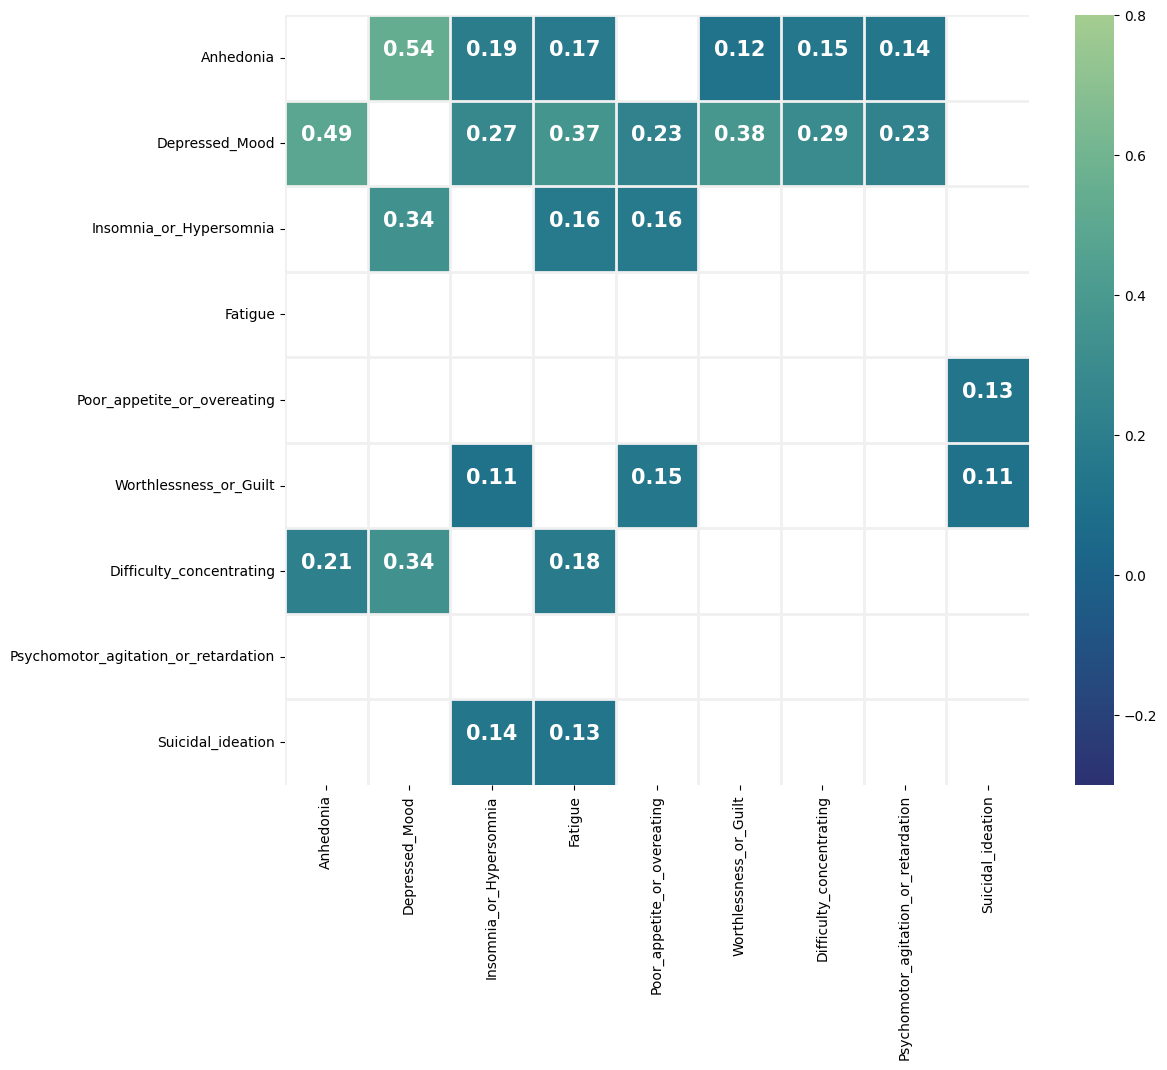

In [45]:
multivariate_coef2_lasso = pd.DataFrame(multivariate_coef2_lasso).round(2)
multivariate_coef2_lasso = multivariate_coef2_lasso.loc[symptoms_columns]
fig, ax = plt.subplots(figsize=(12, 10))
mask = np.zeros(multivariate_coef2.shape)
for idx in range(mask.shape[0]):
    for jdx in range(mask.shape[1]):
        if (idx == jdx) or np.abs(multivariate_coef2_lasso.iloc[idx, jdx]) <= 0.1:
            # print (idx, jdx, multivariate_coef2.iloc[idx, jdx])
            mask[idx, jdx] = True

mask = mask.astype(bool)
sns.heatmap(multivariate_coef2_lasso, annot=False, cmap='crest_r', fmt='', vmin=-0.3, vmax=0.8, mask=mask)

for i, col_i in enumerate(symptoms_columns):
    for j, col_j in enumerate(symptoms_columns):
        if not mask[i, j]:
            corr_text = str(multivariate_coef2_lasso.loc[col_i, col_j])
            ax.text(j + 0.5, i + 0.4, corr_text, ha='center', va='center',
                    fontsize=15, fontweight='bold', color='white')
            
for i in range(9):
    ax.axhline(i, color='#f0f0f0', lw=2)
    ax.axvline(i, color='#f0f0f0', lw=2)

In [44]:
# Infill strategy is mean, run the statistics for 100 trials and report avg coef. Store the std dev as well
multivariate_coef2_lasso_trials = {}
lasso_alpha_trials = {}
num_trials = 500
for trial_num in range(num_trials):
    df = gpt4_df.sample(frac=1, replace=True, random_state=trial_num)
    for column in symptoms_columns:
        X, y, cols = get_symptom_scores(df, column, infill='mean')
        lr = LassoCV(cv = 5, alphas=[1, 10, 0.1, 0.01, 0.001, 0.0001])
        lr.fit(X, y)
        if column not in multivariate_coef2_lasso_trials:
            multivariate_coef2_lasso_trials[column] = []
            lasso_alpha_trials[column] = []
        multivariate_coef2_lasso_trials[column].append(dict(zip(cols, lr.coef_)))
        lasso_alpha_trials[column].append(lr.alpha_)

In [40]:
multivariate_coef2_lasso_avg = {}
multivariate_coef2_lasso_std = {}
multivariate_coef2_lasso_med = {}

for column in symptoms_columns:
    multivariate_coef2_lasso_avg[column] = pd.DataFrame(multivariate_coef2_lasso_trials[column]).T.mean(axis=1)
    multivariate_coef2_lasso_std[column] = pd.DataFrame(multivariate_coef2_lasso_trials[column]).T.std(axis=1)/np.sqrt(num_trials)
    multivariate_coef2_lasso_med[column] = pd.DataFrame(multivariate_coef2_lasso_trials[column]).T.median(axis=1)

multivariate_coef2_lasso_avg = pd.DataFrame(multivariate_coef2_lasso_avg).loc[symptoms_columns]
multivariate_coef2_lasso_std = pd.DataFrame(multivariate_coef2_lasso_std).loc[symptoms_columns]
multivariate_coef2_lasso_med = pd.DataFrame(multivariate_coef2_lasso_med).loc[symptoms_columns]

In [41]:
# Calculate the 90% confidence interval for the coefficients from multivariate_coef2
multivariate_coef2_lasso_ci = []
for idx, symptom in enumerate(symptoms_columns):
    coef_df = pd.DataFrame(multivariate_coef2_lasso_trials[symptom])
    coef_df = coef_df.T
    temp_df = coef_df.quantile([0.05, 0.95], axis=1).reset_index(drop=True).T.apply(lambda x: [round(x[0], 2), round(x[1], 2)], axis=1)
    temp_df = pd.DataFrame(temp_df, columns=[symptom]) 
    multivariate_coef2_lasso_ci.append(temp_df)
multivariate_coef2_lasso_ci = pd.concat(multivariate_coef2_lasso_ci, axis=1).loc[symptoms_columns]

Text(0.5, 1.0, 'Median Coefficients for 500 trials with 90% CI\n')

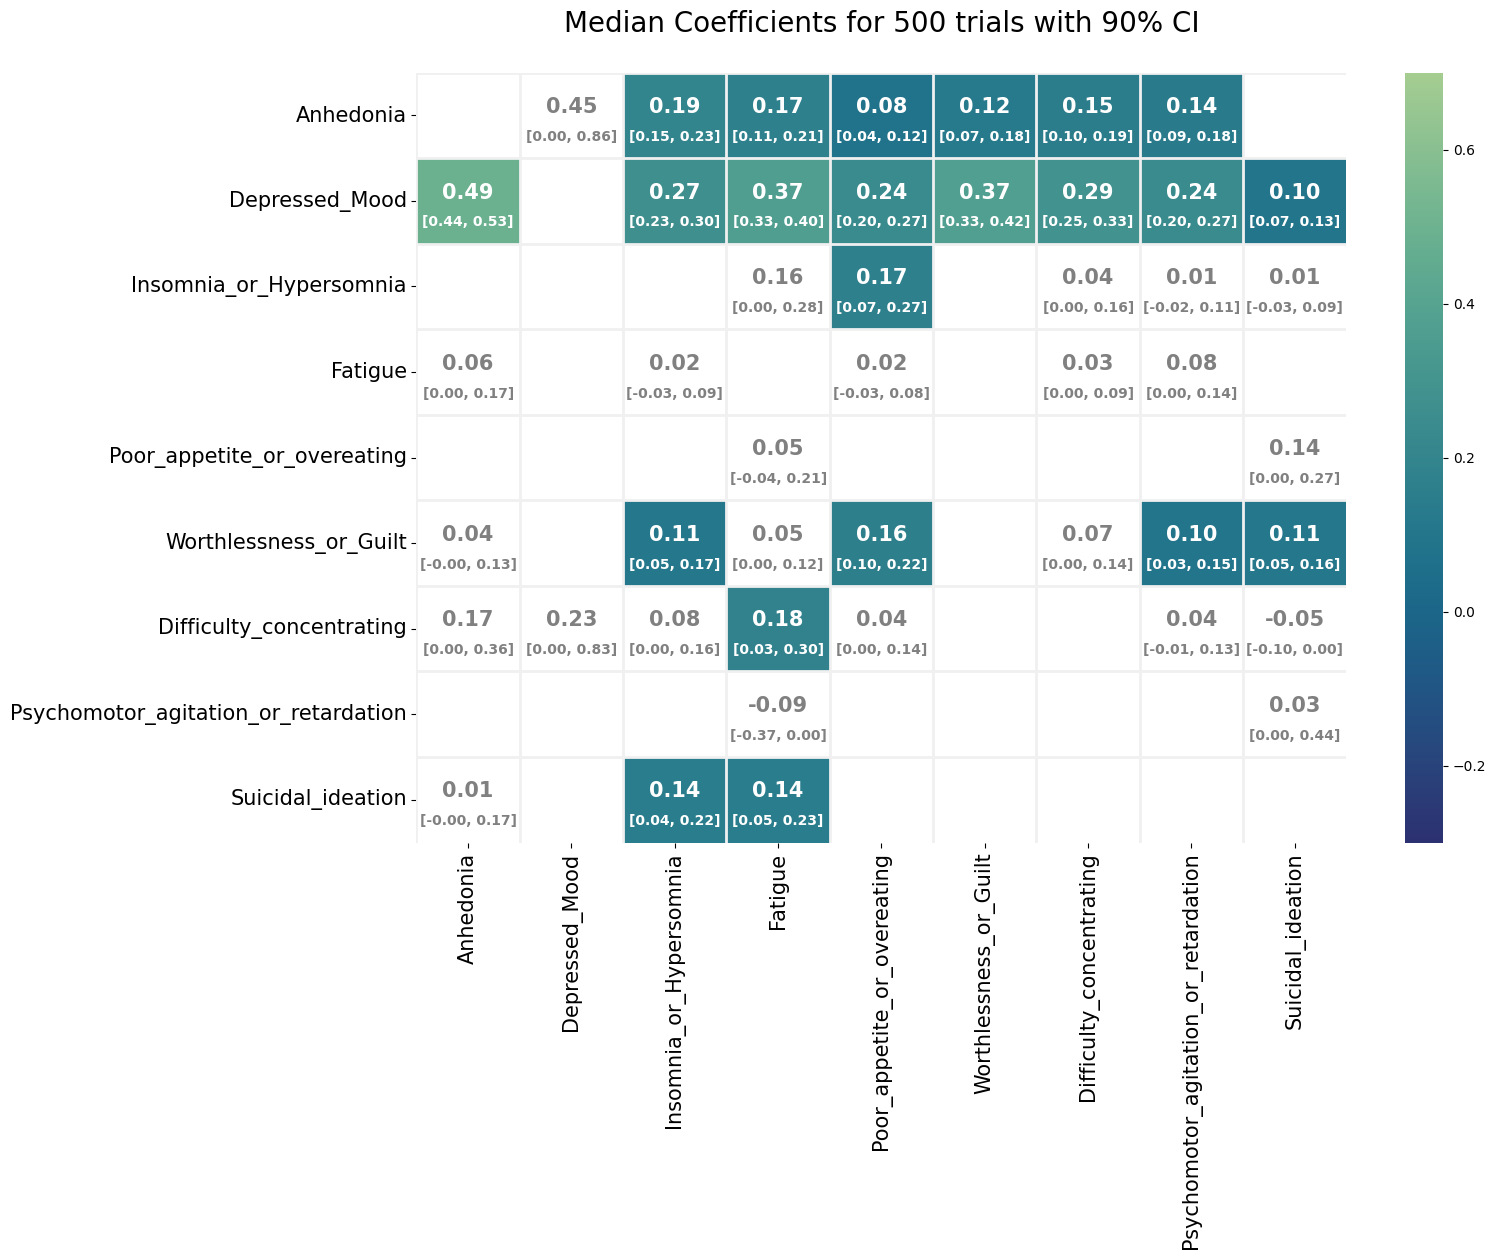

In [51]:
# multivariate_coef2_avg
fig, ax = plt.subplots(figsize=(15, 10))
mask = np.zeros_like(multivariate_coef2_lasso_med)
for idx in range(mask.shape[0]):
    for jdx in range(mask.shape[1]):
        # if (idx != jdx) and np.abs(multivariate_coef2_med.iloc[idx, jdx]) <= 0.1:
        if (idx == jdx) or (multivariate_coef2_lasso_ci.iloc[idx, jdx][0] <= 0 and multivariate_coef2_lasso_ci.iloc[idx, jdx][1] >= 0):
            mask[idx, jdx] = True

mask = mask.astype(bool)             
sns.heatmap(multivariate_coef2_lasso_med, annot=False, cmap='crest_r', fmt='', vmin=-0.3, vmax=0.7, mask=mask)

for i, col_i in enumerate(symptoms_columns):
    for j, col_j in enumerate(symptoms_columns):
        if mask[i, j] == False:
            corr_text = "{:0.2f}".format(multivariate_coef2_lasso_med.loc[col_i, col_j])
            # conf_bounds = str(multivariate_coef2_std.loc[col_i, col_j])
            conf_bounds = "[{:0.2f}, {:0.2f}]".format(multivariate_coef2_lasso_ci.loc[col_i, col_j][0], multivariate_coef2_lasso_ci.loc[col_i, col_j][1])
            # conf_bounds = str([multivariate_coef2_ci.loc[col_i, col_j][0].round(2), multivariate_coef2_ci.loc[col_i, col_j][1].round(2)])
              
            ax.text(j + 0.5, i + 0.4, corr_text, ha='center', va='center',
                    fontsize=15, fontweight='bold', color='white')
            ax.text(j + 0.5, i + 0.75, conf_bounds, ha='center', va='center',
                    fontsize=10, color='white', fontweight='bold')
        elif i!=j:
            corr_text = "{:0.2f}".format(multivariate_coef2_lasso_med.loc[col_i, col_j])
            conf_bounds = "[{:0.2f}, {:0.2f}]".format(multivariate_coef2_lasso_ci.loc[col_i, col_j][0], multivariate_coef2_lasso_ci.loc[col_i, col_j][1])
            if '0.00' not in corr_text:                
                ax.text(j + 0.5, i + 0.4, corr_text, ha='center', va='center',
                        fontsize=15, fontweight='bold', color='gray')
                ax.text(j + 0.5, i + 0.75, conf_bounds, ha='center', va='center',
                        fontsize=10, color='gray', fontweight='bold')
            

ax.set_xticklabels(symptoms_columns, fontsize=15)
ax.set_yticklabels(symptoms_columns, fontsize=15)     

for i in range(9):
    ax.axhline(i, color='#f0f0f0', lw=2)
    ax.axvline(i, color='#f0f0f0', lw=2)

# ax.set_title('Median Coefficients for 500 trials with 90% CI\n(Constrainted)', fontsize=20)
ax.set_title('Median Coefficients for 500 trials with 90% CI\n', fontsize=20)